# Reverse Engineering Rad Guide for Mikuni Hex Jets
By taking a set of measurements denoting the distance between markings on each of the tool's rings it's possible to create lookup tables for density and jet size. Then by applying interpolation/curve fitting, a characteristic polynomial can be obtained. Finally, by specifying the BASELINE setting it is possible to use these characteristic polynomials it's possible to determine the optimal jet size.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns; sns.set_theme()

### Base Measurements

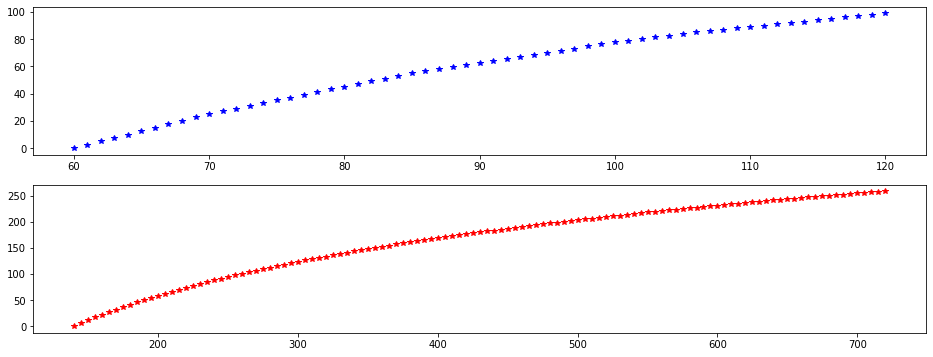

In [2]:
air_density_labels = [(60,70), (70,85), (85,100), (100,105), (105,120)]
air_density_deltas = [2.5, 2, 1.5, 1.25, 1.0]
air_density = [0]
for i,label in enumerate(air_density_labels):
    space = label[1]-label[0]
    air_density.extend([air_density[-1]+air_density_deltas[i]*(j+1) for j in range(space)])
air_density_x = np.arange(60,121)
air_density = np.asarray(air_density)

jet_size_labels = [(140,145), (145,150), (150,155), (155,170), (170,180), (180,185), (185,200), (200,220), 
                   (220,240), (240,250), (250,280), (280,300), (300,340), (340,360), (360,380), (380,400), 
                   (400,420), (420,460), (460,490), (490,500), (500,560), (560,640), (640,700), (700,720)] 
jet_size_deltas = [6, 5.5, 5.25, 5, 4.75, 4.5, 4, 8/2, 7/2, 6.5/2, 6/2, 5.5/2, 5/2, 4.5/2, 4.25/2, 4/2, 
                   3.75/2, 3.5/2, 3.25/2, 3/2, 6/4, 5/4, 4.5/4, 4/4]
jet_size = [0]
for i,label in enumerate(jet_size_labels):
    space = label[1]-label[0]
    jet_size.extend([jet_size[-1]+jet_size_deltas[i]*(j+1) for j in range(space//5)])
jet_size_x = np.arange(140,721,5)
jet_size = np.asarray(jet_size)

# Visualize our result
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,6))
ax1.plot(air_density_x, air_density, "b*")
_ = ax2.plot(jet_size_x, jet_size, "r*")

### Get an interpolation function from the data given

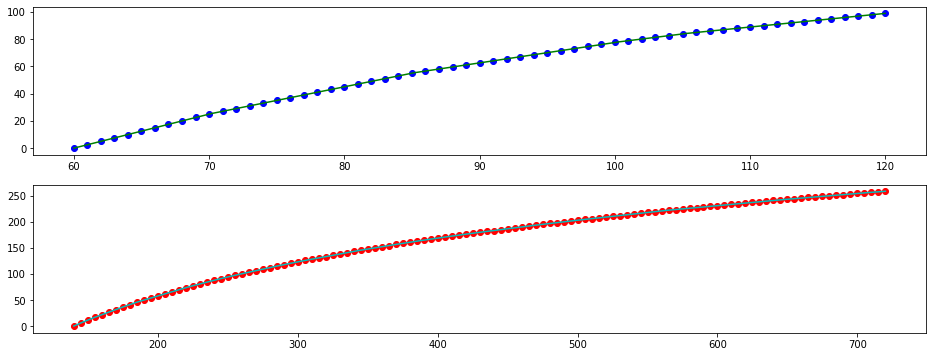

In [3]:
func_air_density = interp1d(air_density_x, air_density)
func_inv_air_density = interp1d(air_density, air_density_x)
func_jet_size = interp1d(jet_size_x, jet_size)
func_inv_jet_size = interp1d(jet_size, jet_size_x)

# Demonstrate ability to intepolate with fine granularity
air_density_interpolants = np.arange(60,120,0.01)
jet_size_interpolants = np.arange(140,720,0.01)

interpolated_air_density = func_air_density(air_density_interpolants)
intepolated_jet_sizes = func_jet_size(jet_size_interpolants)

_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,6))
ax1.plot(air_density_x, air_density, "bo", air_density_interpolants, interpolated_air_density, "g-")
_ = ax2.plot(jet_size_x, jet_size, "ro", jet_size_interpolants, intepolated_jet_sizes, "c-")

### Demonstrate Mapping of Density to Jet Size

In [4]:
# Set a baseline jet size of 220 for 70% air density
BASELINE = (70,220)

jet_size_y = func_jet_size(BASELINE[1])
new_air_density = 85

jet_size_new = jet_size_y + np.abs(func_air_density(BASELINE[0]) - func_air_density(new_air_density))
print(f"New Optimal Jet Size is {int(func_inv_jet_size(jet_size_new))}")

New Optimal Jet Size is 265


## Fit Using Polyfit
By using a polyfit all that needs to be carried over to the Java codebase will be the polynomial coefficients. Could compare the RMS between the fit and the ground truth, however observation should provide sufficient accuracy

[   0.0000566765   -0.030350453     5.67665149   -243.6794945408]
[ 0.0000295062 -0.0011880237  0.4394775474 59.7138049727]
[   0.0000010303   -0.001901179     1.4186186963 -159.3889027293]
[  0.0000175017   0.0002019229   1.0232220687 137.4920938274]


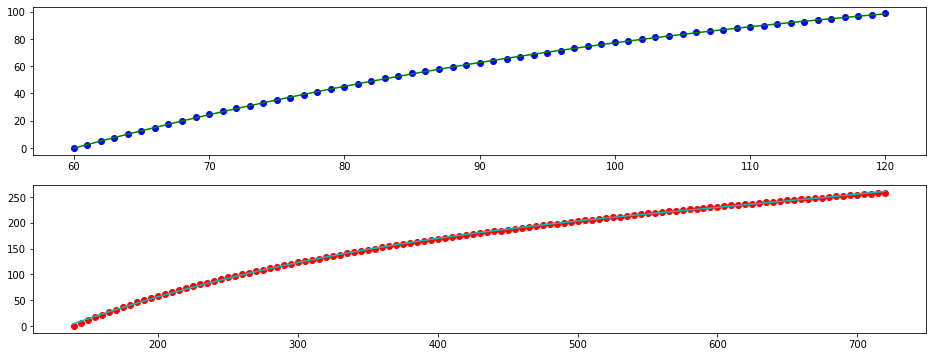

In [5]:
func_air_density = np.poly1d(np.polyfit(air_density_x, air_density, 3))
func_air_density_inv = np.poly1d(np.polyfit(air_density, air_density_x, 3))
func_jet_size = np.poly1d(np.polyfit(jet_size_x, jet_size, 3))
func_jet_size_inv = np.poly1d(np.polyfit(jet_size, jet_size_x, 3))
interpolated_air_density = func_air_density(air_density_interpolants)
intepolated_jet_sizes = func_jet_size(jet_size_interpolants)
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,6))
ax1.plot(air_density_x, air_density, "bo", air_density_interpolants, interpolated_air_density, "g-")
_ = ax2.plot(jet_size_x, jet_size, "ro", jet_size_interpolants, intepolated_jet_sizes, "c-")

# Output coefficients for each of the equations
np.set_printoptions(precision=10, suppress=True)
print(np.polyfit(air_density_x, air_density, 3))
print(np.polyfit(air_density, air_density_x, 3))
print(np.polyfit(jet_size_x, jet_size, 3))
print(np.polyfit(jet_size, jet_size_x, 3))

## Sensitivity Analysis: Battery Temperature as a Proxy to Ambient Temperature

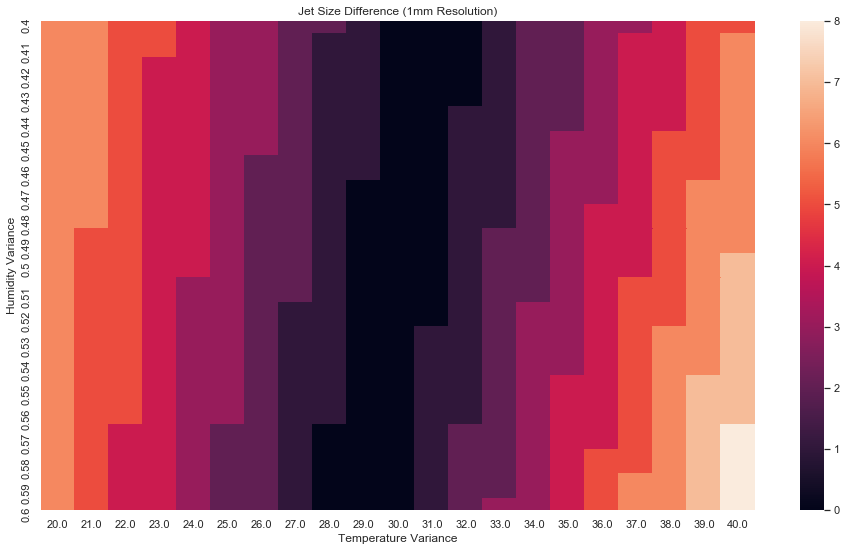

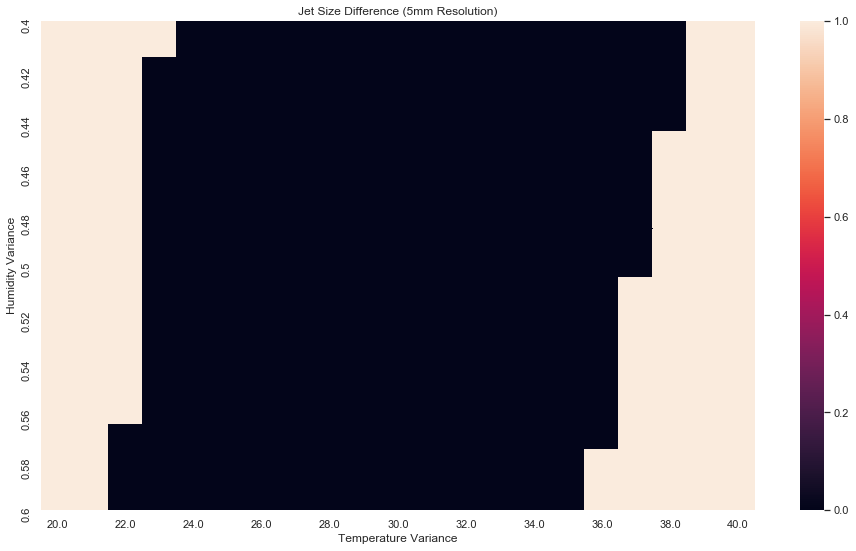

In [34]:
RD = 287.058;
RV = 461.495;
M = 17.62;
TN = 243.12;

# Set baseline density and jet size. A jet size of 600 is used as larger jet 
# sizes are more prone to error due to temperature sensor variance
air_density_bl = 94.0612739224
jetsize=200

# We have a dedicated pressure sensor with finite error
pressure = 1013.25
# Humidity from 20 to 80 as this is the "high" accuracy regime of most sensors
humidities = np.linspace(40, 60, 21)
# Explore effect using battery temp has given that temp is 30 degrees, plus or minus 10 degrees
temperature = np.linspace(20, 40, 21)

# Array to hold the delta to the expected result
humidity_v_temp_js = np.zeros(shape=(21,21))

humidities /= 100;
a = np.log(humidities[len(humidities)//2]) + (M * temperature) / (TN + temperature);
dp = TN * a / (M - a);
p1 = 6.1078 * 10**(7.5 * dp / (dp + 237.3));
pv = p1 * humidities[len(humidities)//2];
pd = pressure - pv;
p = 100*(pd / (RD * (temperature+273.15))) + (pv / (RV * (temperature+273.15)));
p /= 1.225;
p *= 100;

# Use the resultant polynomial fits from before to see impact on pressure changes caused by temperature variance
air_density_fn = lambda x: 0.0000566765*x**3-0.030350453*x**2+5.67665149*x-243.679494541
jet_size_fn = lambda x: 0.0000010303*x**3-0.001901179*x**2+1.4186186963*x-159.3889027293
jet_size_fn_inv = lambda x: (0.0000175017*x**3+0.0002019229*x**2+1.0232220687*x+137.4920938274).astype(int)

feature_space_jetsize = jet_size_fn(jetsize)
feature_space_jetsize += np.abs(air_density_fn(air_density_bl) - air_density_fn(p))
ideal_measurement = jet_size_fn_inv(feature_space_jetsize)[len(feature_space_jetsize)//2]

for i, humidity in enumerate(humidities):
    a = np.log(humidity) + (M * temperature) / (TN + temperature);
    dp = TN * a / (M - a);
    p1 = 6.1078 * 10**(7.5 * dp / (dp + 237.3));
    pv = p1 * humidity;
    pd = pressure - pv;
    p = 100*(pd / (RD * (temperature+273.15))) + (pv / (RV * (temperature+273.15)));
    p /= 1.225;
    p *= 100;

    feature_space_jetsize = jet_size_fn(jetsize)
    feature_space_jetsize += np.abs(air_density_fn(air_density_bl) - air_density_fn(p))
    real_space_jetsize = jet_size_fn_inv(feature_space_jetsize)
    humidity_v_temp_js[i] = real_space_jetsize - ideal_measurement

fig = plt.figure(figsize=(16,9))
ax = sns.heatmap(humidity_v_temp_js)
ax.set_xlabel("Temperature Variance")
ax.set_ylabel("Humidity Variance")
ax.set_xticklabels(temperature)
ax.set_yticklabels(humidities)
ax.set_title("Jet Size Difference (1mm Resolution)")

fig = plt.figure(figsize=(16,9))
ax = sns.heatmap(humidity_v_temp_js//5)
ax.set_xlabel("Temperature Variance")
ax.set_ylabel("Humidity Variance")
ax.set_xticklabels(temperature)
ax.set_yticklabels(humidities)
_ = ax.set_title("Jet Size Difference (5mm Resolution)")

for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

plt.savefig("temp.png", figsize=(21,16), dpi=200)

##### Observations:
* A $\pm$10 Degrees C range can result in a jet that is 20mm too large/small being used for large jet sizes (600mm)
* Smaller jets (200mm) only result in a jet that is 5mm too large/small being used
* The $\pm$10 Degree Temperature range was selected based off my 23.333 C apt. reading as 32 C
* Datsun operates around 150-250 mm jets. V8 stop around 300 mm
